In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import chi

In [2]:
plt.rcParams['figure.figsize'] = [12, 12]

We'll begin by setting up the data.

In [3]:
n = 1024

In [4]:
sigma = .1

In [5]:
x = np.arange(1/n, 1 + 1/n, 1/n)

In [6]:
np.random.seed(42)

In [7]:
eps = norm.rvs(loc=0, scale=1, size=n, random_state=42)

In [8]:
f = lambda x: np.sqrt(x * (1 - x)) * np.sin((2.1 * np.pi) / (x + 0.05))

In [9]:
Y = f(x) + sigma * eps

Here's a scatter plot of the dataset.

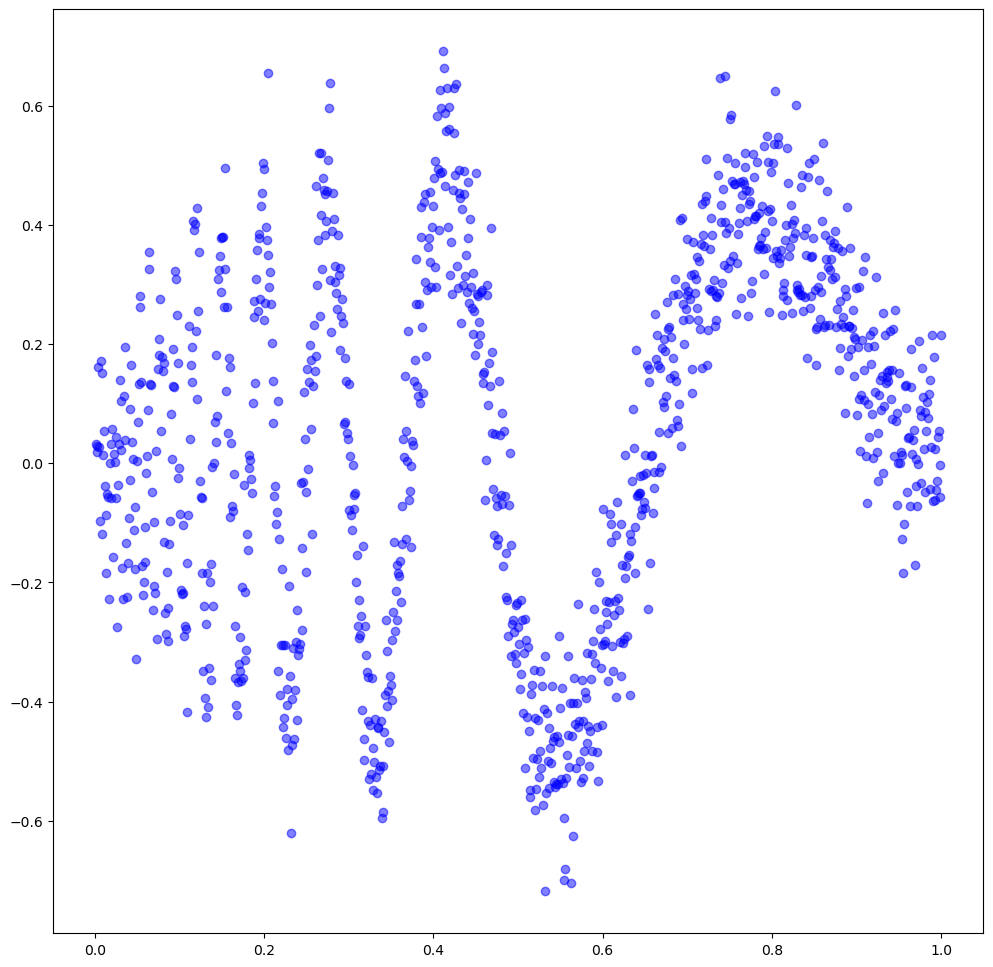

In [10]:
plt.scatter(x, Y, color='blue', alpha=0.5)

# Part (a)

We'll define a bunch of functions to do the cosine basis regression and plot it.

In [11]:
def cos_basis(n):
    """
        Compute the first n cosine basis functions.
        return: list of functions of length n
    """
    basis = []
    
    for j in range(n):
        if j == 0:
            phi = lambda x: 1
            basis.append(phi)
        else:
            phi = lambda x, k=j: np.sqrt(2) * np.cos(k * np.pi * x)
            basis.append(phi)
    
    return basis

In [12]:
def cos_coeffs(X, Y):
    """
        Compute the coefficients of a regression function of
            Y on X with respect to the cosine basis.
        X, Y: numpy arrays of floats with X lying in [0,1]
        return: coeffs, a numpy array of floats
    """
    coeffs = []
    n = len(X)
    basis_funcs = cos_basis(n)
    
    for j in range(n):
        phi = basis_funcs[j]
        beta = np.mean(Y * phi(X))
        coeffs.append(beta)
    
    coeffs = np.array(coeffs)
    
    return coeffs

In [13]:
def cos_reg(X, Y, J):
    """
        Compute the partial sum of length J of Y on X.
        X, Y: numpy arrays of floats with X lying in [0,1]
        return: Python function f
    """
    basis = cos_basis(J)
    coeffs = cos_coeffs(X, Y)
    
    def f(x):
        out = [phi(x) for phi in basis]
        return np.dot(coeffs[:J], out)
    
    return f

In [14]:
def cos_conf_funcs(X, Y, J, alpha):
    """
        Compute the partial sum for the regression of Y on X with
            respect to the cosine basis, of length J as well as
            upper and lower bounds for a 1-alpha confidence band
        X, Y: numpy arrays of floats with X lying in [0,1]
        J: the number of terms of the partial sum
        alpha: the parameter for the confidence band
        return: l, r, u, the lower bound, regression function, and
            upper bound, respectively
    """
    n = len(X)
    basis = cos_basis(n)
    coeffs = cos_coeffs(X, Y)
    
    # The regression function
    r = cos_reg(X, Y, J)
    
    k = n // 4
    sigma = np.sqrt((n / k) * (coeffs**2)[n-k+1:n].sum())
    
    dist = chi
    ch = dist.ppf(1-alpha, df=J)
    
    # The function a in the definition of the confidence band
    def a(x):
        out = np.array([phi(x) for phi in basis[:J]])
        return np.sqrt((out**2).sum())
    
    # The function c in the definition of the confidence band
    c = lambda x: a(x) * sigma * ch / np.sqrt(n)
    
    # The upper and lower bands for the confidence band
    l = lambda x: r(x) - c(x)
    u = lambda x: r(x) + c(x)
    
    return l, r, u

In [15]:
def plot_cos_conf_band(X, Y, J, alpha, ax):
    xs = np.linspace(0, 1, 1000)
    
    l, r, u = cos_conf_funcs(X, Y, J, alpha)
    
    L = list(map(l, xs))
    R = list(map(r, xs))
    U = list(map(u, xs))
    
    ax.plot(xs, L, c='green', alpha=0.8)
    ax.plot(xs, R, c='black', alpha=0.8)
    ax.plot(xs, U, c='orange', alpha=0.8)
    ax.scatter(X, Y, c='blue', alpha=0.2)
    ax.set_xlabel(r'$X$')
    ax.set_ylabel(r'$Y$')
    ax.set_title(rf'Confidence band for cosine basis regression, $J={J}$')

Here's the confidence band for $J=50$.

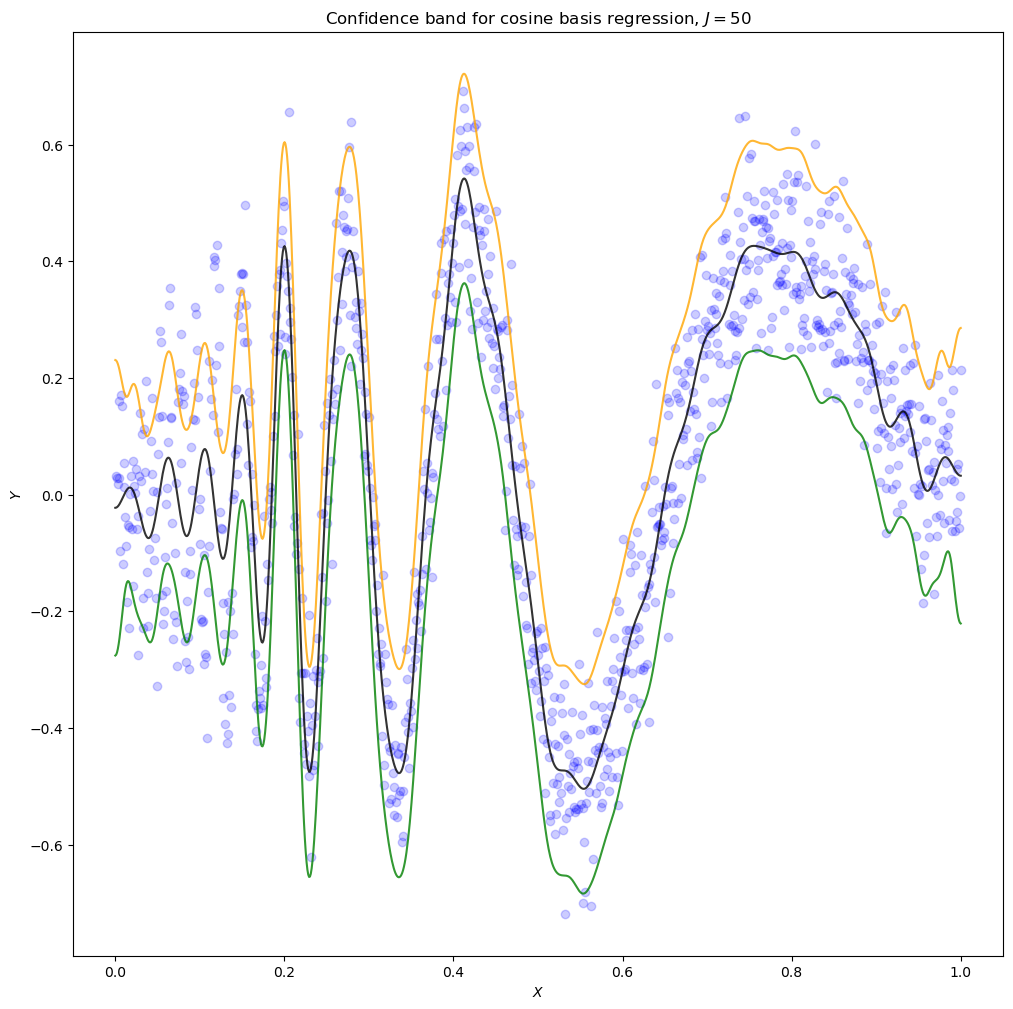

In [16]:
ax = plt.gca()
plot_cos_conf_band(x, Y, 50, 0.05, ax)

And here are the confidence bands for different values of $J$.

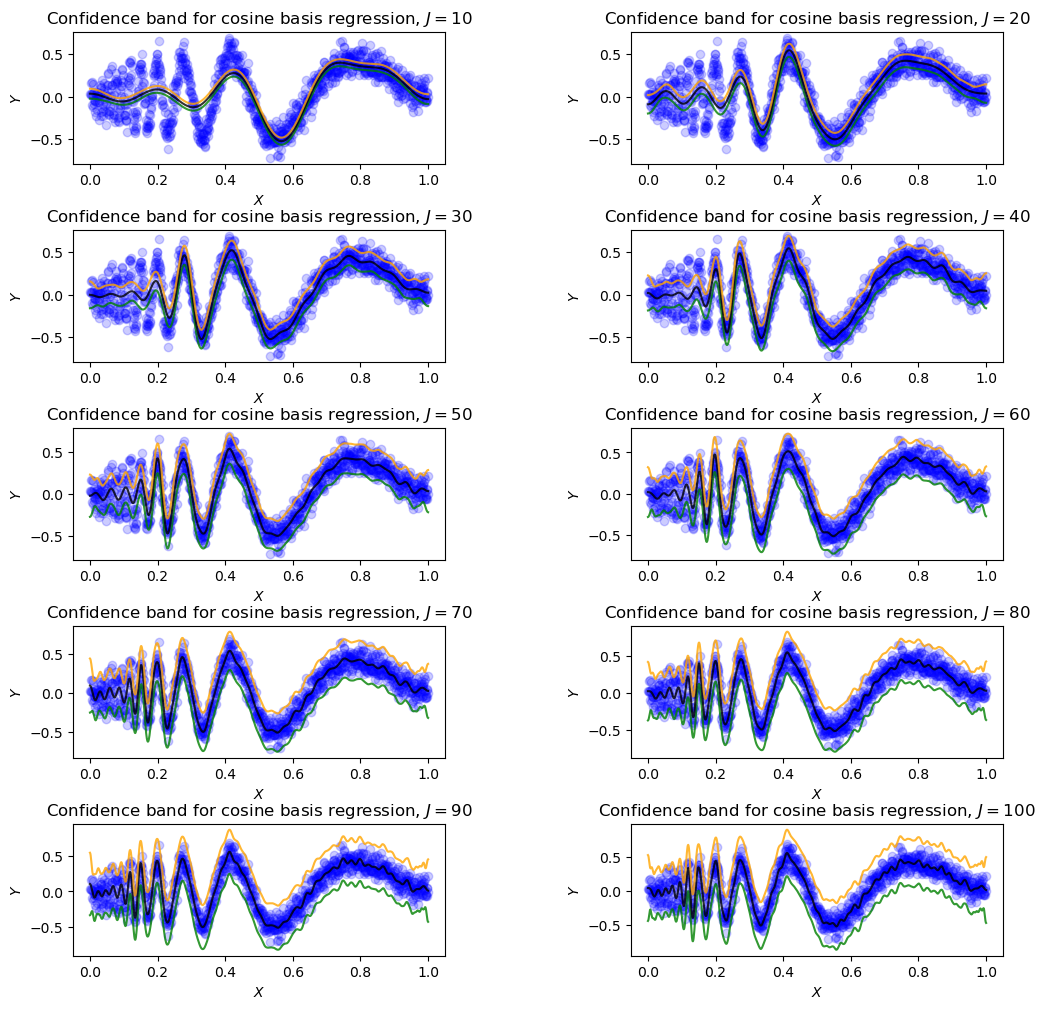

In [17]:
fig, axs = plt.subplots(5, 2)
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(1, 11):
    J = 10*i
    ax = axs[(i - 1) // 2][(i - 1) % 2]
    plot_cos_conf_band(x, Y, J, 0.05, ax)

# Part (b)

Again we'll define a bunch of functions and do the plotting.

In [18]:
def phi(x):
    """
        The father Haar wavelet
    """
    if 0 <= x and x < 1:
        return 1
    else:
        return 0

In [19]:
def psi_mother(x):
    """
        The mother Haar wavelet
    """
    if 0 <= x and x <= 1/2:
        return -1
    elif 1/2 < x <= 1:
        return 1
    else:
        return 0

In [20]:
def psi(j, k):
    """
        Return the function psi_{j,k} in the Haar wavelet basis
    """
    return lambda x: 2**(j/2) * psi_mother(2**j * x - k)

In [21]:
def haar_wave_reg(X, Y):
    """
        Perform Haar wavelet regression of Y on X.
        X, Y: numpy arrays of floats with X lying in [0,1]
        return: f, the Haar wavelet regression function
    """
    
    n = len(X)
    J = int(np.log2(n)) + 1
    
    alpha = (np.array(list(map(phi, X))) * Y).mean()

    D = np.zeros(2**J - 1)
    for j in range(J):
        for k in range(2**j):
            psijk = psi(j, k)
            D[2**j + k - 1] = (np.array(list(map(psijk, X))) * Y).mean()
    
    # Estimate sigma and apply universal thresholding to D
    D_sub = D[2**(J-1):]
    sigma = np.sqrt(n) * np.median(np.abs(D_sub)) / 0.6745
    beta = D * (np.abs(D) > sigma * np.sqrt(2 * np.log(n) / n))
    
    psis = [psi(j,k) for j in range(J) for k in range(2**j)]
    
    # Compute the regression function
    def f(x):
        wavelet_output = np.array([psi(x) for psi in psis])
        return alpha * phi(x) + np.dot(beta, wavelet_output)
    
    return f

In [22]:
def plot_haar_wave_reg(X, Y, ax):
    """
        Plot X, Y and the Haar wavelet regression function
        on the axes ax.
        X, Y: numpy arrays of floats with X lying in [0,1]
        ax: the axes on which to plot
    """
    f = haar_wave_reg(X, Y)
    x = np.linspace(0,1,10000)
    y = list(map(f, x))
    
    ax.scatter(X, Y, color='blue', alpha=0.5)
    ax.plot(x, y, color='green', alpha=0.8)
    ax.set_xlabel(r'$X$')
    ax.set_ylabel(r'$Y$')
    ax.set_title('Haar wavelet regression')

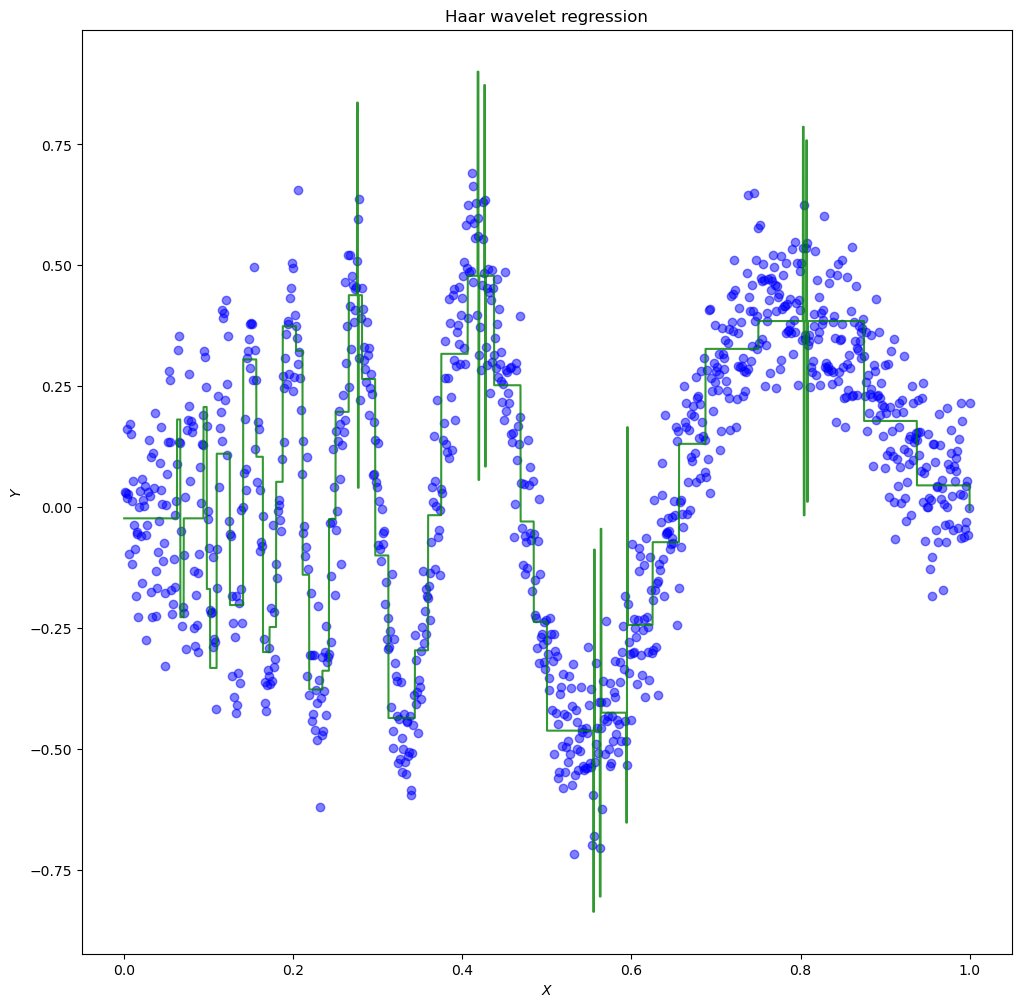

In [23]:
ax = plt.gca()
plot_haar_wave_reg(x, Y, ax)